In [7]:
#!pip install tensorflow

     -------------------------------------- 272.8/272.8 MB 4.6 MB/s eta 0:00:00
     ------------------------------------- 420.6/420.6 kB 12.8 MB/s eta 0:00:00
     --------------------------------------- 14.7/14.7 MB 10.2 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 11.8 MB/s eta 0:00:00
     ---------------------------------------- 5.6/5.6 MB 10.9 MB/s eta 0:00:00
     -------------------------------------- 126.5/126.5 kB 7.8 MB/s eta 0:00:00
     --------------------------------------- 24.4/24.4 MB 10.4 MB/s eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 11.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ----------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
opentelemetry-proto 1.14.0 requires protobuf~=3.13, but you have protobuf 4.22.3 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.
google-cloud-storage 1.31.0 requires google-auth<2.0dev,>=1.11.0, but you have google-auth 2.17.3 which is incompatible.
google-cloud-core 1.7.1 requires google-auth<2.0dev,>=1.24.0, but you have google-auth 2.17.3 which is incompatible.
google-api-core 1.25.1 requires google-auth<2.0dev,>=1.21.1, but you have google-auth 2.17.3 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     -------------------------------------- 151.7/151.7 kB 8.8 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.4.8-py3-none-any.whl size=1439795 sha256=55547538bde7becb8a694c213f53f1aacf1770b22709aa675a3f9b4de5254975
  Stored in directory: c:\users\rmpaw\appdata\local\pip\cache\wheels\05\94\dc\81042da9bced43ff430bc02043d213d9e4b210b584c39e31c1
Successfully built jax
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.1
    Uninstalling protobuf-3.19.1:
      Successfully uninstalled protobuf-3.19.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.42.0
    Uninstalling grpcio-1.42.0:
      Successfully uninstalled grpcio-1.42.0
  Attempting uninstall: google-auth
    Found existing installation: google-auth 1.33.0
    Uninstalling google-auth-1.33.0:
      Successfully uninstall

In [1]:
import os
import time
import glob
import pandas as pd
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt
import gc
import IPython.display as ipd 
import pickle
from sklearn.preprocessing import StandardScaler
import numpy as np
import scipy.signal
from playsound import playsound
import miniaudio
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model, Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten
from keras.layers import Dropout, Input, Activation
from keras.optimizers import Nadam, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import load_model
from keras.layers import BatchNormalization
from keras import regularizers
import math
from keras.callbacks import LearningRateScheduler

In [2]:
def generate_fb_and_mfcc(signal, sample_rate):

    # Pre-Emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(
        signal[0],
        signal[1:] - pre_emphasis * signal[:-1])

    # Framing
    frame_size = 0.025
    frame_stride = 0.01

    # Convert from seconds to samples
    frame_length, frame_step = (
        frame_size * sample_rate,
        frame_stride * sample_rate)
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    # Make sure that we have at least 1 frame
    num_frames = int(
        np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))

    # Pad Signal to make sure that all frames have equal
    # number of samples without truncating any samples
    # from the original signal
    pad_signal = np.append(emphasized_signal, z)

    indices = (
        np.tile(np.arange(0, frame_length), (num_frames, 1)) +
        np.tile(
            np.arange(0, num_frames * frame_step, frame_step),
            (frame_length, 1)
        ).T
    )
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Window
    frames *= np.hamming(frame_length)

    # Fourier-Transform and Power Spectrum
    NFFT = 512

    # Magnitude of the FFT
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))

    # Power Spectrum
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Filter Banks
    nfilt = 40

    low_freq_mel = 0

    # Convert Hz to Mel
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))

    # Equally spaced in Mel scale
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)

    # Convert Mel to Hz
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)

    # Numerical Stability
    filter_banks = np.where(
        filter_banks == 0,
        np.finfo(float).eps,
        filter_banks)

    # dB
    filter_banks = 20 * np.log10(filter_banks)
    
    return filter_banks

In [3]:
#list1=list(pd.DataFrame(os.listdir('train'))[0].apply(lambda x: "train\\"+x).values)
list1=list(pd.DataFrame(os.listdir(r'C:\Users\rmpaw\OneDrive - stevens.edu\SpokenLanguageDetection\test\test'))[0].apply(lambda x: x).values)

for i in range(42,round(len(list1)/500)):
    sigdf=pd.DataFrame()
    start = time.time()
    for j in range(500):
        signal, sample_rate = sf.read(list1[i*500+j])
        df=pd.DataFrame(signal.reshape(-1, len(signal)))
        df['sample_rate']=sample_rate
        df['filename']=list1[i*500+j]
        sigdf=pd.concat([sigdf,df])
    sigdf=sigdf.reset_index(drop=True)
    filehandler = open(r'ex_data\singal_df_'+str(i*500+1)+'_'+str(i*500+500)+'.pkl',"wb")
    pickle.dump(sigdf,filehandler)
    filehandler.close()
    hours, rem = divmod(time.time()-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print('ex_data\singal_df_'+str(i*500+1)+'_'+str(i*500+500)+'.csv')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


In [4]:
#list1=list(pd.DataFrame(os.listdir('train'))[0].apply(lambda x: "train\\"+x).values)
list1=list(pd.DataFrame(os.listdir(r'C:\Users\rmpaw\OneDrive - stevens.edu\SpokenLanguageDetection\test\test'))[0].apply(lambda x: x).values)

df1=pd.DataFrame(list1)
df1['lang']=df1[0].apply(lambda x: x.split('_')[0][-2:])
df1['gender']=df1[0].apply(lambda x: x.split('_')[1])
df1['user_id']=df1[0].apply(lambda x: x.split('_')[-1].split('.')[0])
df1['fragment']=df1[0].apply(lambda x: x.split('_')[-1].split('.')[1])
df1['edit']=df1[0].apply(lambda x: x.split('_')[-1].split('.')[2])
df1

,0,lang,gender,user_id,fragment,edit
0,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de,f,63f5b79c76cf5a1a4bbd1c40f54b166e,fragment1,flac
1,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de,f,63f5b79c76cf5a1a4bbd1c40f54b166e,fragment10,flac
2,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de,f,63f5b79c76cf5a1a4bbd1c40f54b166e,fragment11,flac
3,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de,f,63f5b79c76cf5a1a4bbd1c40f54b166e,fragment12,flac
4,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de,f,63f5b79c76cf5a1a4bbd1c40f54b166e,fragment13,flac
...,...,...,...,...,...,...
535,es_m_08111ce8d6a7ebc6cd2c27e62a3d98f0.fragment...,es,m,08111ce8d6a7ebc6cd2c27e62a3d98f0,fragment87,flac
536,es_m_08111ce8d6a7ebc6cd2c27e62a3d98f0.fragment...,es,m,08111ce8d6a7ebc6cd2c27e62a3d98f0,fragment88,flac
537,es_m_08111ce8d6a7ebc6cd2c27e62a3d98f0.fragment...,es,m,08111ce8d6a7ebc6cd2c27e62a3d98f0,fragment89,flac
538,es_m_08111ce8d6a7ebc6cd2c27e62a3d98f0.fragment...,es,m,08111ce8d6a7ebc6cd2c27e62a3d98f0,fragment9,flac


In [5]:
df1.groupby('lang')['user_id'].nunique()

lang
de    2
en    2
es    2
Name: user_id, dtype: int64

In [6]:
german_m = []
german_f = []
spanish_m = []
spanish_f = []
english_m = []
english_f = []
for i in range(len(df1)):
    if df1['lang'][i]=='de' and df1['gender'][i]=='f':
        german_f.append(df1[0][i])
    if df1['lang'][i]=='de' and df1['gender'][i]=='m':
        german_m.append(df1[0][i])
    if df1['lang'][i]=='en' and df1['gender'][i]=='f':
        english_f.append(df1[0][i])
    if df1['lang'][i]=='en' and df1['gender'][i]=='m':
        english_m.append(df1[0][i])
    if df1['lang'][i]=='es' and df1['gender'][i]=='f':
        spanish_f.append(df1[0][i])
    if df1['lang'][i]=='es' and df1['gender'][i]=='m':
        spanish_m.append(df1[0][i])

In [7]:
file = "OneDrive - stevens.edu/SpokenLanguageDetection/test/test/"

In [38]:
stream = miniaudio.stream_file(file+german_m[0])
with miniaudio.PlaybackDevice() as device:
    device.start(stream)
    input("Audio file playing in the background. Enter to stop playback: ")

Audio file playing in the background. Enter to stop playback: 


In [9]:
sig_spanish_m, sr_spanish_m = sf.read(file+spanish_m[0])
sig_spanish_f, sr_spanish_f = sf.read(file+spanish_f[0])
sig_english_m, sr_english_m = sf.read(file+english_m[0])
sig_english_f, sr_english_f = sf.read(file+english_f[0])
sig_german_m, sr_german_m = sf.read(file+german_m[0])
sig_german_f, sr_german_f = sf.read(file+german_f[0])

Text(0.5, 0, 'Time [sec]')

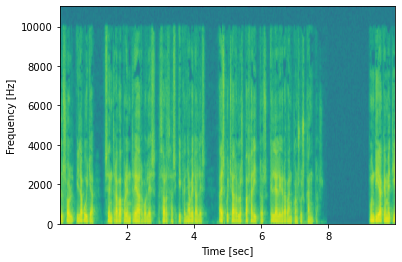

In [10]:
Pxx, freqs, bins, im = plt.specgram(sig_spanish_m, Fs=sr_spanish_m)

# add axis labels
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time in samples')

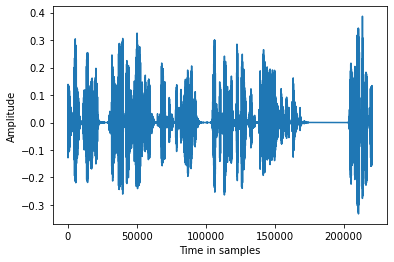

In [11]:
plt.plot(sig_spanish_m)

# add axis labels
plt.ylabel('Amplitude')
plt.xlabel('Time in samples')

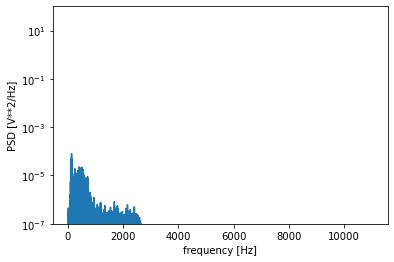

In [12]:
(f, S) = scipy.signal.periodogram(sig_spanish_m, sr_spanish_m, scaling='density')
plt.semilogy(f, S)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

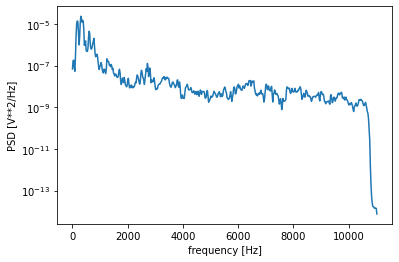

In [39]:
(f, S)= scipy.signal.welch(sig_german_m, sr_german_m, nperseg=1024)

plt.semilogy(f, S)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

Text(0.5, 0, 'sample')

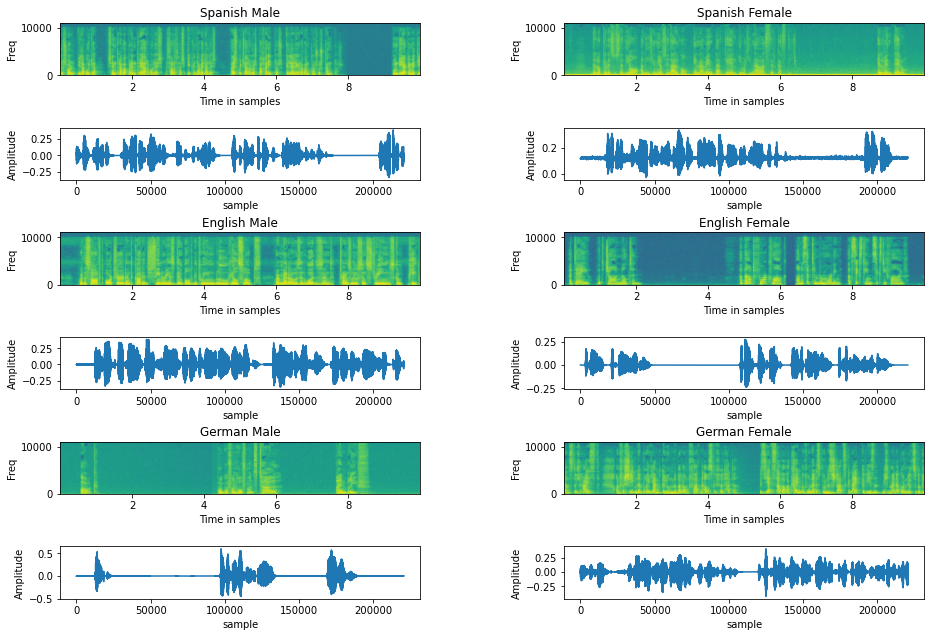

In [17]:
# using padding
plt.subplots_adjust(left=0,
                    bottom=0,
                    right=2.0,
                    top=2.0,
                    wspace=0.4,
                    hspace=1)
#plt.show()
plt.subplot(6,2,1)
plt.title('Spanish Male')
Pxx, freqs, bins, im = plt.specgram(sig_spanish_m, Fs=sr_spanish_m)

# add axis labels
plt.ylabel('Freq')
plt.xlabel('Time in samples')
plt.subplot(6,2,2)
plt.title('Spanish Female')
Pxx, freqs, bins, im = plt.specgram(sig_spanish_f ,Fs=sr_spanish_f)
plt.ylabel('Freq')
plt.xlabel('Time in samples')

plt.subplot(6,2,3)
plt.plot(sig_spanish_m)
plt.ylabel('Amplitude')
plt.xlabel('sample')

plt.subplot(6,2,4)
plt.plot(sig_spanish_f)
plt.ylabel('Amplitude')
plt.xlabel('sample')

# add axis labels
# plt.ylabel('Freq')
# plt.xlabel('Time in samples')
plt.subplot(6,2,5)
plt.title('English Male')
Pxx, freqs, bins, im = plt.specgram(sig_english_m, Fs=sr_english_m)
# add axis labels
plt.ylabel('Freq')
plt.xlabel('Time in samples')
plt.subplot(6,2,6)
plt.title('English Female')
Pxx, freqs, bins, im = plt.specgram(sig_english_f ,Fs=sr_english_f)
plt.ylabel('Freq')
plt.xlabel('Time in samples')

plt.subplot(6,2,7)
plt.plot(sig_english_m)
plt.ylabel('Amplitude')
plt.xlabel('sample')

plt.subplot(6,2,8)
plt.plot(sig_english_f)
plt.ylabel('Amplitude')
plt.xlabel('sample')

# add axis labels
# plt.ylabel('Freq')
# plt.xlabel('Time in samples')
plt.subplot(6,2,9)
plt.title('German Male')
Pxx, freqs, bins, im = plt.specgram(sig_german_m ,Fs=sr_german_m)
# add axis labels
plt.ylabel('Freq')
plt.xlabel('Time in samples')
plt.subplot(6,2,10)
plt.ylabel('Freq')
plt.xlabel('Time in samples')
plt.title('German Female')
Pxx, freqs, bins, im = plt.specgram(sig_german_f ,Fs=sr_german_f)

plt.subplot(6,2,11)
plt.plot(sig_german_m)
plt.ylabel('Amplitude')
plt.xlabel('sample')

plt.subplot(6,2,12)
plt.plot(sig_german_f)
plt.ylabel('Amplitude')
plt.xlabel('sample')

In [6]:
X_train,X_test,y_train,y_test = train_test_split(df1,df1['lang'],stratify = df1[['lang','gender','user_id','edit']],test_size = 0.78,random_state = 420)
print(X_train['lang'].value_counts())
print(X_test['lang'].value_counts())

de    5366
es    5365
en    5346
Name: lang, dtype: int64
en    19014
es    18995
de    18994
Name: lang, dtype: int64


In [78]:
list1=X_train[0].values

for i in range(round(len(list1)/500)):
    sigdf=pd.DataFrame()
    start = time.time()
    for j in range(500):
        signal, sample_rate = sf.read(list1[i*500+j])
        df=pd.DataFrame(signal.reshape(-1, len(signal)))
        df['sample_rate']=sample_rate
        df['filename']=list1[i*500+j]
        sigdf=pd.concat([sigdf,df])
    sigdf=sigdf.reset_index(drop=True)
    filehandler = open(r'ex_data\singal_df_'+str(i*500+1)+'_'+str(i*500+j+1)+'.pkl',"wb")
    pickle.dump(sigdf,filehandler)
    filehandler.close()
    hours, rem = divmod(time.time()-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print('ex_data\singal_df_'+str(i*500+1)+'_'+str(i*500+j+1)+'.csv')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

ex_data\singal_df_1_500.csv
00:08:12.23
ex_data\singal_df_501_1000.csv
00:08:19.91
ex_data\singal_df_1001_1500.csv
00:08:11.50
ex_data\singal_df_1501_2000.csv
00:08:17.88
ex_data\singal_df_2001_2500.csv
00:08:06.83
ex_data\singal_df_2501_3000.csv
00:08:10.14
ex_data\singal_df_3001_3500.csv
00:08:14.32
ex_data\singal_df_3501_4000.csv
00:08:16.95
ex_data\singal_df_4001_4500.csv
00:08:27.09
ex_data\singal_df_4501_5000.csv
00:08:20.96
ex_data\singal_df_5001_5500.csv
00:08:24.45
ex_data\singal_df_5501_6000.csv
00:08:28.48
ex_data\singal_df_6001_6500.csv
00:08:30.14
ex_data\singal_df_6501_7000.csv
00:08:23.40
ex_data\singal_df_7001_7500.csv
00:08:31.53
ex_data\singal_df_7501_8000.csv
00:08:29.93
ex_data\singal_df_8001_8500.csv
00:08:27.33
ex_data\singal_df_8501_9000.csv
00:08:30.27
ex_data\singal_df_9001_9500.csv
00:08:23.53
ex_data\singal_df_9501_10000.csv
00:08:25.53
ex_data\singal_df_10001_10500.csv
00:08:20.80
ex_data\singal_df_10501_11000.csv
00:08:26.70
ex_data\singal_df_11001_11500.cs

In [9]:
i=0
file = open(r'ex_data\singal_df_'+str(i*500+1)+'_'+str(i*500+500)+'.pkl','rb')
sigdf = pickle.load(file)
file.close()
sigdf['lang']=sigdf['filename'].apply(lambda x: x.split('_')[0][-2:])
sigdf['gender']=sigdf['filename'].apply(lambda x: x.split('_')[1])
sigdf['user_id']=sigdf['filename'].apply(lambda x: x.split('_')[-1].split('.')[0])
sigdf['fragment']=sigdf['filename'].apply(lambda x: x.split('_')[-1].split('.')[1])
sigdf['edit']=sigdf['filename'].apply(lambda x: x.split('_')[-1].split('.')[2])
sigdf

,0,1,2,3,4,5,6,7,8,9,...,220498,220499,sample_rate,filename,220500,lang,gender,user_id,fragment,edit
0,-0.020905,-0.031860,-0.028931,-0.020203,-0.002075,0.010193,0.013611,0.004120,-0.009247,-0.012665,...,0.000000,0.000000,22050,train\es_f_1d27c6d589eeff17973ffd0b7a77a70a.fr...,NaN,es,f,1d27c6d589eeff17973ffd0b7a77a70a,fragment5,speed5
1,-0.007965,-0.007202,0.003601,0.010895,0.014069,0.005890,-0.005829,-0.019653,-0.028564,-0.035706,...,0.018646,0.011688,22050,train\es_f_53b555eab2b3baada380f7d3ede20b20.fr...,NaN,es,f,53b555eab2b3baada380f7d3ede20b20,fragment14,pitch4
2,-0.070190,-0.066132,-0.063599,-0.062103,-0.059601,-0.055115,-0.050598,-0.046295,-0.043060,-0.038849,...,0.015717,0.017517,22050,train\de_f_d94712992f41e3d8d21f22274b3d8fd9.fr...,NaN,de,f,d94712992f41e3d8d21f22274b3d8fd9,fragment24,noise6
3,-0.005951,-0.011993,-0.009888,-0.012848,-0.014374,-0.015961,-0.013062,-0.013824,-0.015961,-0.020050,...,-0.006683,-0.006561,22050,train\en_f_10134f409d9b7b0b95fed6e025febcad.fr...,NaN,en,f,10134f409d9b7b0b95fed6e025febcad,fragment25,noise7
4,0.001556,0.001404,0.001617,0.002106,0.002625,0.002869,0.001709,0.000946,0.001740,0.002380,...,-0.038666,-0.038940,22050,train\es_m_b8e0e6f56f02e6f8f79cc360958e5982.fr...,NaN,es,m,b8e0e6f56f02e6f8f79cc360958e5982,fragment8,noise4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.016266,-0.013611,0.000397,0.020569,0.032318,0.035248,0.035309,0.038361,0.045197,0.046844,...,0.019928,0.016479,22050,train\es_m_d5b91a4ffb1ead826b7968ec19cbfa1c.fr...,NaN,es,m,d5b91a4ffb1ead826b7968ec19cbfa1c,fragment3,noise10
496,0.000122,0.001282,0.002045,0.002472,0.002960,0.003479,0.003418,0.002960,0.002747,0.002960,...,0.013397,0.016937,22050,train\de_m_fc6bd6bb9d66a89bb8d8a8a7efa23e6b.fr...,NaN,de,m,fc6bd6bb9d66a89bb8d8a8a7efa23e6b,fragment4,noise6
497,0.012054,0.015717,0.015717,0.018982,0.018433,0.018677,0.016052,0.018707,0.022522,0.032166,...,-0.018799,-0.018768,22050,train\de_m_d22535879801cc9c4452d9ed9de5bf61.fr...,NaN,de,m,d22535879801cc9c4452d9ed9de5bf61,fragment20,speed4
498,-0.002380,0.003052,0.003204,-0.004486,-0.004395,0.001587,0.006195,-0.012115,-0.008118,-0.005341,...,0.000000,0.000000,22050,train\de_f_2825fa225d6ca4800f0cf0504b76ca65.fr...,NaN,de,f,2825fa225d6ca4800f0cf0504b76ca65,fragment11,pitch6


In [43]:
list1=X_train[0].values
language_dummies=pd.DataFrame()
MFCC_array = []
sc = StandardScaler()
start=time.time()
for i in range(round(len(list1)/500)):
    file = open(r'ex_data\singal_df_'+str(i*500+1)+'_'+str(i*500+500)+'.pkl','rb')
    sigdf = pickle.load(file)
    singal_values=np.array(sigdf.iloc[:,:220500])
    language_dummies = pd.concat([language_dummies,pd.get_dummies(sigdf['filename'].apply(lambda x: x.split('_')[0][-2:]))])
    for i in range(0,len(singal_values)):
        MFCC = generate_fb_and_mfcc(singal_values[i], sigdf['sample_rate'][i])
        MFCC_sc = sc.fit_transform(MFCC)
        MFCC_array.append(MFCC_sc)
    
MFCC_array = np.array(MFCC_array)
filehandler = open(r'ex_data\MFCC_arrays.pkl',"wb")
pickle.dump(MFCC_array,filehandler)
filehandler.close()

filehandler = open(r'ex_data\language_dummies.pkl',"wb")
pickle.dump(language_dummies,filehandler)
filehandler.close()

hours, rem = divmod(time.time()-start, 3600)
minutes, seconds = divmod(rem, 60)

print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

02:40:24.57


In [45]:
X_train_MFCC,X_test_MFCC,y_train_MFCC,y_test_MFCC = train_test_split(MFCC_array,language_dummies,stratify = language_dummies,test_size = 0.20,random_state = 0)
X_train_MFCC = X_train_MFCC.reshape(-1,1000,40,1)
X_test_MFCC = X_test_MFCC.reshape(-1,1000,40,1)

In [78]:
X_train_MFCC.shape

(12800, 1000, 40, 1)

In [58]:
start=time.time()
input_shape = (1000,40,1)

model = Sequential()
model.add(Conv2D(32,(7, 7), activation='relu', padding='valid', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(64,(5,5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(512,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


adam = Adam()
def step_decay(epoch):
    initial_lrate = 0.00158
    drop = 0.9
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
checkpoint = ModelCheckpoint(
                'model.h5',
                monitor='val_acc',
                verbose=0,
                save_best_only=True,
                mode='max'
                )

lrate = LearningRateScheduler(step_decay)
model.fit(X_train_MFCC,
          y_train_MFCC,
          epochs=9,
          callbacks=[checkpoint, lrate],
          verbose=2,
          validation_data=(X_test_MFCC, y_test_MFCC),
          batch_size=32)

hours, rem = divmod(time.time()-start, 3600)
minutes, seconds = divmod(rem, 60)

print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 1/9
400/400 - 1334s - loss: 0.7079 - accuracy: 0.7370 - val_loss: 0.2464 - val_accuracy: 0.9125 - lr: 0.0014 - 1334s/epoch - 3s/step
Epoch 2/9
400/400 - 1351s - loss: 0.1522 - accuracy: 0.9444 - val_loss: 0.7528 - val_accuracy: 0.7681 - lr: 0.0013 - 1351s/epoch - 3s/step
Epoch 3/9
400/400 - 1339s - loss: 0.0914 - accuracy: 0.9676 - val_loss: 0.1603 - val_accuracy: 0.9384 - lr: 0.0012 - 1339s/epoch - 3s/step
Epoch 4/9
400/400 - 1331s - loss: 0.0574 - accuracy: 0.9803 - val_loss: 0.1582 - val_accuracy: 0.9419 - lr: 0.0010 - 1331s/epoch - 3s/step
Epoch 5/9
400/400 - 1324s - loss: 0.0397 - accuracy: 0.9870 - val_loss: 0.1417 - val_accuracy: 0.9541 - lr: 9.3297e-04 - 1324s/epoch - 3s/step
Epoch 6/9
400/400 - 1325s - loss: 0.0278 - accuracy: 0.9903 - val_loss: 0.1026 - val_accuracy: 0.9669 - lr: 8.3968e-04 - 1325s/epoch - 3s/step
Epoch 7/9
400/400 - 1328s - loss: 0.0299 - accuracy: 0.9904 - val_loss: 0.4905 - val_accuracy: 0.8641 - lr: 7.5571e-04 - 1328s/epoch - 3s/step
Epoch 8/9
400/4

In [59]:
filehandler = open(r'ex_data\model.pkl',"wb")
pickle.dump(model,filehandler)
filehandler.close()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_3
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_4
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_5
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_6
......vars
.........0
.........1
.........2
.........3
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\conv2d_4
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
..

In [71]:
y_pred = model.predict(X_train_MFCC)
y_train1 = []
label={0:'de',1:'en',2:'es'}
for i in range(0,len(y_train_MFCC)):
    argmax = label[np.argmax(y_train_MFCC.iloc[i,:])]
    y_train1.append(argmax)
y_pred1 = []
for i in range(0,len(y_train_MFCC)):
    argmax = label[np.argmax(y_pred[i,:])]
    y_pred1.append(argmax)

400/400 [==============================] - 326s 815ms/step


In [54]:
y_pred

array([[1.18316166e-07, 9.99996185e-01, 3.67341750e-06],
       [2.07718131e-12, 9.99999881e-01, 6.15733313e-08],
       [8.20629372e-13, 1.08308784e-09, 1.00000000e+00],
       ...,
       [8.38450420e-10, 9.99999881e-01, 9.89855238e-08],
       [2.79180984e-10, 7.18146822e-08, 9.99999881e-01],
       [7.83233523e-01, 2.13708773e-01, 3.05774994e-03]], dtype=float32)

In [72]:
confusion_matrix(y_train1,y_pred1)

array([[4262,    4,    8],
       [   0, 4256,    0],
       [   3,    0, 4267]], dtype=int64)

In [73]:
print(classification_report(y_train1,y_pred1))

              precision    recall  f1-score   support

          de       1.00      1.00      1.00      4274
          en       1.00      1.00      1.00      4256
          es       1.00      1.00      1.00      4270

    accuracy                           1.00     12800
   macro avg       1.00      1.00      1.00     12800
weighted avg       1.00      1.00      1.00     12800



In [74]:
y_pred_test = model.predict(X_test_MFCC)
y_test1 = []
label={0:'de',1:'en',2:'es'}
for i in range(0,len(y_test_MFCC)):
    argmax = label[np.argmax(y_test_MFCC.iloc[i,:])]
    y_test1.append(argmax)
y_pred2 = []
for i in range(0,len(y_test_MFCC)):
    argmax = label[np.argmax(y_pred_test[i,:])]
    y_pred2.append(argmax)

100/100 [==============================] - 80s 796ms/step


In [75]:
confusion_matrix(y_test1,y_pred2)

array([[1054,    5,    9],
       [   5, 1055,    4],
       [   2,    1, 1065]], dtype=int64)

In [76]:
print(classification_report(y_test1,y_pred2))

              precision    recall  f1-score   support

          de       0.99      0.99      0.99      1068
          en       0.99      0.99      0.99      1064
          es       0.99      1.00      0.99      1068

    accuracy                           0.99      3200
   macro avg       0.99      0.99      0.99      3200
weighted avg       0.99      0.99      0.99      3200



In [ ]:
### Add samples of predictions
